# Melting Temperature Tm Plotting

In [1]:
import os, sys
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
from matplotlib import rc

mpl.rcParams['pdf.fonttype'] = 42

from matplotlib.ticker import ScalarFormatter
%matplotlib inline

## Constants

In [2]:
#############################
#                           #
#                           #
#        CONSTANTS          #
#                           #
#                           #
#############################
LOCAL_DIR = '.'
DATA_DIR = LOCAL_DIR+'/data'
OUTPUT_DIR = LOCAL_DIR+'/figures/melting_temperature_tm'
if not os.path.exists(OUTPUT_DIR): os.makedirs(OUTPUT_DIR)

RAW_DATA_SHEETNAME = 'melting_temperature_tm'

In [3]:
from importlib import reload
sys.path.append(LOCAL_DIR) #Helper Functions Here
import FramHelperScripts
reload(FramHelperScripts)
FHS = FramHelperScripts.FramHelperFunctions(DATA_DIR)

## Load Data

In [4]:
#############################
#                           #
#                           #
#        LOAD DATA          #
#                           #
#                           #
#############################


df = pd.read_excel(
    FHS.get_data_filename(), sheet_name=RAW_DATA_SHEETNAME
)[0:45][['Protein', 'Tm D']]

df = FHS.add_manuscript_name_to_df(
    df, synonym_column='Protein',
    new_column='manuscript_name'
)[['manuscript_name', 'Tm D']]


df['delta_wt'] = df.apply(
    lambda row: row['Tm D'] - np.mean(df[df.manuscript_name=='WT TEM-1']['Tm D']),
    axis=1
)
df['sample_mean'] = df.apply(
    lambda row: np.mean(df[df.manuscript_name==row['manuscript_name']]['Tm D']),
    axis=1
)
df['sample_delta_wt'] = df.apply(
    lambda row: np.mean(df[df.manuscript_name==row['manuscript_name']]['Tm D']) - \
                np.mean(df[df.manuscript_name=='WT TEM-1']['Tm D']),
    axis=1
)

#add 50's even though they aren't there - will indicate in plot
df = pd.concat([
    df, 
    pd.DataFrame({
        'manuscript_name': ['50.a', '50.a', '50.a','50.b', '50.b', '50.b'],
        'Tm D': np.full(6, 0),
        'delta_wt': np.full(6, 0),
        'sample_mean': np.full(6, 0),
        'sample_delta_wt': np.full(6, 0)
    })
]).reset_index().drop('index', axis='columns')

#remove non-existant samples from sample order
sample_order = FHS.get_sample_order(df.manuscript_name)

## Plot Figures

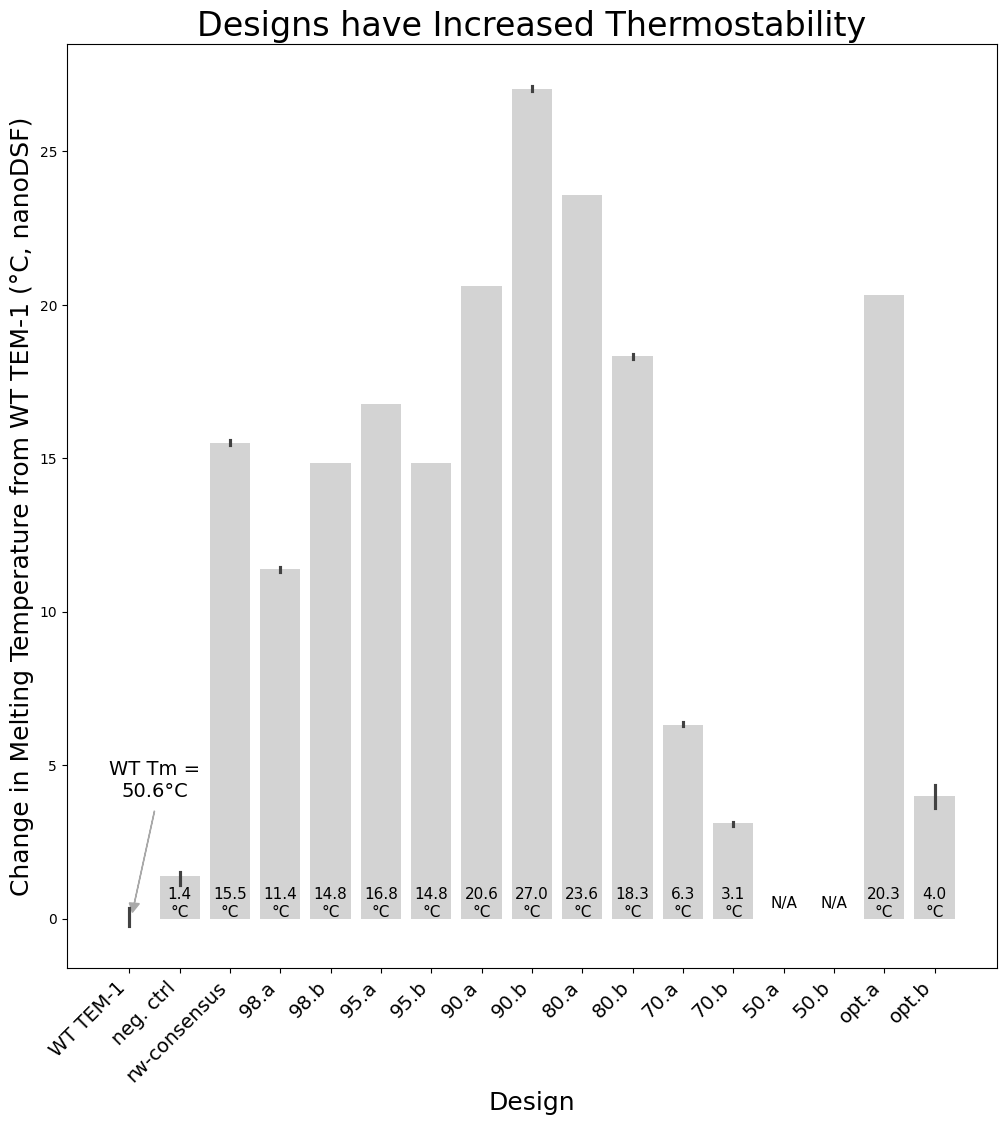

In [5]:
def plot_final():
    fig, ax = plt.subplots(nrows=1, ncols=1)
    fig.set_size_inches(12, 12)

    #plot final call
    
    bp = sns.barplot(
        data=df,
        x='manuscript_name', y='delta_wt',
        color='lightgray', linewidth=1, order=sample_order,
        ax=ax
    )
    
    #add text values to result
    for idx, samplename in enumerate(sample_order):
        bar_details = bp.patches[idx]
        val = '{0:.1f}\n°C'.format(
            np.mean(df[df.manuscript_name==samplename]['delta_wt'])
        )

        y=.5
        x=bar_details.xy[0] + (bar_details.get_width() / 2)
        fontsize=11

        if samplename in ['50.a', '50.b']: val = 'N/A'
        elif samplename == 'WT TEM-1': 
            val = 'WT Tm =\n{0:.1f}°C'.format(
                np.mean(df[df.manuscript_name==samplename]['Tm D'])
            )
            y=4.5
            x=0.5
            fontsize=14
            ax.arrow(.5, 3.5, -.4, -3.0, width=.005, 
                     head_width=.2, color='darkgray')

        ax.text(
            x=x, y=y,
            horizontalalignment='center', verticalalignment='center',
            s=val, fontsize=fontsize
        )

        
    #set text
    ax.set_title('Designs have Increased Thermostability', fontsize=24)
    ax.set_ylabel('Change in Melting Temperature from WT TEM-1 (°C, nanoDSF)', fontsize=18)
    ax.set_xlabel('Design', fontsize=18)
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')
        label.set_fontsize(14)

    fig.savefig(OUTPUT_DIR+'/Tm_FINAL.pdf')

plot_final()